# Project 2 - Autonomous Driving

By Laura Madrid & Lucas Noritomi-Hartwig

Autonomous driving is one of the major research venues these days. A lot of 
effort is devoted to it by both the academics as well as industry. In this 
project you'll familiarize yourself with some of the most important problems 
that arise in the field of autonomous driving.

The input to your algorithm is a stereo image pair and the camera parameters. 
You will also have available a set of training images where the cars have been 
annotated with 2D bounding boxes as well as viewpoint. Furthermore, you'll have 
a few images where the road has been annotated. Here are the tasks to solve:

### 1. Compute disparity between the two stereo images. We do not mind if you use existing code as long as you include a description of the algorithm you used, showing you understand what it is doing.

### 2. Compute depth of each pixel. Compute 3D location of each pixel.

In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import os
from skimage import io

In [3]:
# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        img_path = os.path.join(directory, filename)
        # Avoiding ".DS_store" file that may or may not appear in directory
        if os.path.isfile(img_path) and not filename.startswith('.'):
            try:
                img = io.imread(img_path)
                images.append(img)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return images

In [4]:
def convert_to_grayscale(images):
    return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

In [5]:
# Path to the directories containing the images
LEFT_IMAGE_DIR = "project2/train/image_left"
RIGHT_IMAGE_DIR = "project2/train/image_right"
GROUND_TRUTH_DIR = "project2/train/gt_image_left"
num_images = 134

# Load left images
left_images = load_images_from_directory(LEFT_IMAGE_DIR)
left_images_gray = convert_to_grayscale(left_images)
assert(len(left_images) == num_images)

# Load right images
right_images = load_images_from_directory(RIGHT_IMAGE_DIR)
right_images_gray = convert_to_grayscale(right_images)
assert(len(right_images) == num_images)

# Load ground truth images
ground_truth_images = load_images_from_directory(GROUND_TRUTH_DIR)
assert(len(ground_truth_images) == num_images)

In [6]:
# Camera parameters
FOCAL_LENGTH = 7.215377000000e+02  # milimetres from files in calib folders
BASELINE = 540  # 54 centimetres from https://www.cvlibs.net/datasets/kitti/

In [7]:
def sum_of_square_diff(left_image_patch, right_image_patch) -> float:
    """
    Calculate the sum of squared differences between individual pixels.
    
    Args:
        left_image_patch (numpy.ndarray): Pixel block from left image.
        right_image_patch (numpy.ndarray): Pixel block from right image.
        
    Returns:
        float: Sum of absolute differences between the two pixel blocks.
    """
    # Check that images are of the same shape.
    if left_image_patch.shape != right_image_patch.shape:
        return -1

    return np.sum(np.square(left_image_patch - right_image_patch))

In [8]:
def compare_blocks(y, x, left_block, right_image, block_size=5, 
                   search_range=25):
    """
    Compare a block from the left image with blocks in the right image along the
    same horizonatl line to find the best match.
    
    Args:
        y (int): Row index of the left block.
        x (int): Column index of the left block.
        left_block (numpy.ndarray): Pixel block from the left image.
        right_image (numpy.ndarray): Entire right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        tuple: (y, x) indices of the best matching block in the right image.
    """
    # Define upper bound of search range in the right image.
    x_min = max(0, x - search_range)
    x_max = min(right_image.shape[1], x + block_size)

    # Initialize the minimum sum of squared differences (SSD) and its index.
    min_ssd, index_of_min_ssd = float("inf"), None

    # Iterate over the search range in the right image.
    y_p_block_size = y + block_size
    for x in range(x_min, x_max):
        right_block = right_image[y:y_p_block_size, x:x + block_size]
        ssd = sum_of_square_diff(left_block, right_block)

        # Update the min sum of squared differences and its index accordingly.
        if ssd < min_ssd:
            min_ssd, index_of_min_ssd = ssd, (y, x)

    return index_of_min_ssd

In [9]:
def normalize_map(map):
    map = (map - np.min(map))
    return map / np.max(map)

In [10]:
def calculate_disparity_and_depth_map(left_image, right_image, block_size=5, 
                                      search_range=8):
    """
    Calculate the disparity map between two images using block matching.

    Args:
        left_image (numpy.ndarray): Left image.
        right_image (numpy.ndarray): Right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        disparity_map (numpy.ndarray): Disparity map.
        depth_map (numpy.ndarray): Depth map.
    """
    h, w = left_image.shape
    disparity_map = np.zeros((h, w))

    # Iterate over the entire image except for the borders
    h_m_block_size, w_m_block_size = h - block_size, w - block_size
    for y in tqdm(range(block_size, h_m_block_size)):
        y_p_block_size = y + block_size
        for x in range(block_size, w_m_block_size):
            left_block = left_image[y:y_p_block_size, x:x + block_size]
            min_index = compare_blocks(y, x, left_block, right_image,
                                       block_size, search_range)
            # Compute pixel disparity
            disparity_map[y, x] = abs(min_index[1] - x)

    # return disparity_map
    return normalize_map(disparity_map)

In [11]:
def calculate_disparity_and_depth_map_cv2(left_image, right_image, block_size=5, 
                                          search_range=8):
    """
    Calculate the disparity map between two images using block matching.

    Args:
        left_image (numpy.ndarray): Left image.
        right_image (numpy.ndarray): Right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        disparity_map (numpy.ndarray): Disparity map.
        depth_map (numpy.ndarray): Depth map.
    """

    # Initialize the StereoSGBM object
    stereo = cv2.StereoSGBM_create(minDisparity=0,
                                   numDisparities=16 * search_range,
                                   blockSize=block_size,
                                   uniquenessRatio=10,
                                   speckleWindowSize=100,
                                   speckleRange=32,
                                   disp12MaxDiff=1,
                                   P1=8 * 3 * block_size ** 2,
                                   P2=32 * 3 * block_size ** 2)

    # Compute disparity
    disparity_map = stereo.compute(left_image, right_image)

    # return disparity_map
    return normalize_map(disparity_map)

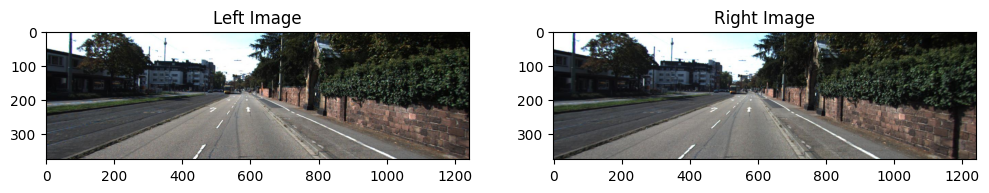

In [12]:
# Load sample images
left_image = left_images[0]
right_image = right_images[0]

plt.figure(figsize=(12, 6))

# Plot the left image in the first subplot
plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
plt.imshow(left_image)
plt.title("Left Image")
plt.grid(False)

# Plot the right image in the first subplot
plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
plt.imshow(right_image)
plt.title("Right Image")
plt.grid(False)

# Display the plot
plt.show()

left_image_gray = left_images_gray[0]
right_image_gray = right_images_gray[0]

100%|██████████| 365/365 [01:37<00:00,  3.74it/s]
/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_44942/2452112810.py:14: RuntimeWarning: divide by zero encountered in divide
  depth_map = (FOCAL_LENGTH * BASELINE) / disparity_map


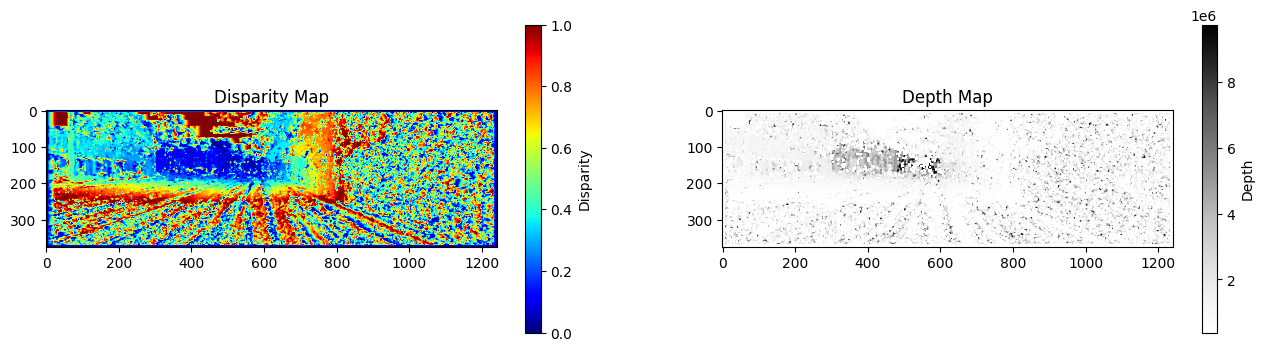

In [13]:
show_dis_dep = True
if show_dis_dep:
    # Set block size and search range
    block_size = 5
    search_range = 25

    # Compute disparity and depth map
    disparity_map = calculate_disparity_and_depth_map(left_image_gray, 
                                                    right_image_gray, 
                                                    block_size, 
                                                    search_range)

    # Compute depth map
    depth_map = (FOCAL_LENGTH * BASELINE) / disparity_map

    # Set figure size
    plt.figure(figsize=(16, 4))

    # Visualize the computed disparity map
    plt.subplot(1, 2, 1)
    plt.imshow(disparity_map, cmap="jet")
    plt.colorbar(label='Disparity')
    plt.title("Disparity Map")
    plt.grid(False)

    # Visualize the computed depth map
    plt.subplot(1, 2, 2)
    plt.imshow(depth_map, cmap="Greys")
    plt.colorbar(label='Depth')
    plt.title("Depth Map")
    plt.grid(False)

    # Display the plot
    plt.show()

/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_44942/3612186489.py:13: RuntimeWarning: divide by zero encountered in divide
  depth_map_cv2 = (FOCAL_LENGTH * BASELINE) / disparity_map_cv2


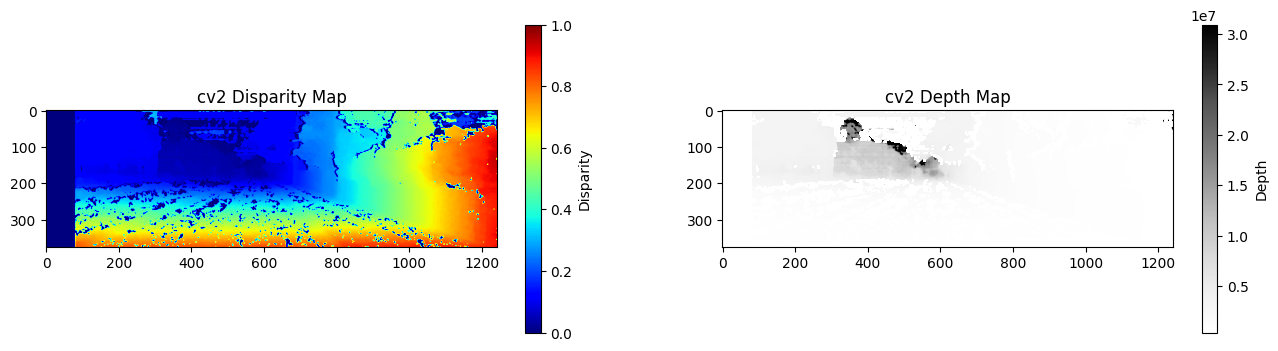

In [14]:
# Set block size and search range
block_size = 5
search_range = 5

# Compute disparity map by cv2
disparity_map_cv2 = calculate_disparity_and_depth_map_cv2(left_image_gray, 
                                                          right_image_gray, 
                                                          block_size, 
                                                          search_range)

# Compute depth map
# depth_map_cv2 = (FOCAL_LENGTH * BASELINE) / (np.abs(disparity_map_cv2))
depth_map_cv2 = (FOCAL_LENGTH * BASELINE) / disparity_map_cv2

# Set figure size
plt.figure(figsize=(16, 4))

# Visualize the computed disparity map
plt.subplot(1, 2, 1)
plt.imshow(disparity_map_cv2, cmap="jet")
plt.colorbar(label='Disparity')
plt.title("cv2 Disparity Map")
plt.grid(False)

# Visualize the computed depth map
plt.subplot(1, 2, 2)
plt.imshow(depth_map_cv2, cmap="Greys")
plt.colorbar(label='Depth')
plt.title("cv2 Depth Map")
plt.grid(False)

# Display the plot
plt.show()

Camera matrix, $K$, found from "calib" folder:

\[
\begin{bmatrix}
0.7215377 & 0 & 0.6095593 \\
0 & 0.7215377 & 0.172854 \\
0 & 0 & 1 \\
\end{bmatrix}
\]

Given by $f = 0.7215377$, $p_x = 0.6095593$, and $p_y = 0.172854$.

We invert the matrix to get: 1.38592

\[
\begin{bmatrix}
1.38592 & 0 & -0.84480 \\
0 & 1.38592 & -0.23956 \\
0 & 0 & 1 \\
\end{bmatrix}
\]

Thus, the 3D location of the pixel $(x,\, y)$ is equal to:

\[
\begin{bmatrix}
w(1.38592x - 0.84480) \\
w(1.38592y - 0.23956) \\
w \\
\end{bmatrix}
\]

We know that the $z$-component of the vector is the depth of the pixel. From
this, we compute the 3D locations of each pixel. 

In [27]:
def compute_3D_location(location_2D, depth_value):
    x, y = location_2D
    return depth_value * np.array([1.38592 * x - 0.84480, 
                                   1.38592 * y - 0.23956,
                                   1])

def compute_3D_locations(image, depth_map):
    height, width = image.shape[:2]
    locations_3D = np.zeros((height, width, 3))
    print(locations_3D.shape)
    for y in range(height):
        for x in range(width):
            locations_3D[y, x] = compute_3D_location((x, y), depth_map[y, x])
    return locations_3D


In [29]:
pixel_3D_locations = compute_3D_locations(left_image, depth_map_cv2)
print(pixel_3D_locations)

(375, 1242, 3)
[[[           -inf            -inf             inf]
  [            inf            -inf             inf]
  [            inf            -inf             inf]
  ...
  [ 1.93170772e+10 -2.69624881e+06  1.12550042e+07]
  [ 5.31648582e+10 -7.41468422e+06  3.09512616e+07]
  [ 5.32077542e+10 -7.41468422e+06  3.09512616e+07]]

 [[           -inf             inf             inf]
  [            inf             inf             inf]
  [            inf             inf             inf]
  ...
  [ 1.37088935e+10  9.15646147e+06  7.98742234e+06]
  [ 1.32912145e+10  8.87032205e+06  7.73781539e+06]
  [ 1.33019385e+10  8.87032205e+06  7.73781539e+06]]

 [[           -inf             inf             inf]
  [            inf             inf             inf]
  [            inf             inf             inf]
  ...
  [ 1.30761753e+10  1.92928642e+07  7.61877208e+06]
  [ 1.28884505e+10  1.90005480e+07  7.50333614e+06]
  [ 1.28988495e+10  1.90005480e+07  7.50333614e+06]]

 ...

 [[           -inf 

### 3. Train a road classifier on a set of annotated images, and compute road pixels in your image. Which features would you use? Try to use both 2D and 3D features.

In [15]:
# Set block size and search range
block_size = 5
search_range = 5
    
# disparity_maps = [calculate_disparity_and_depth_map_cv2(
#     cv2.cvtColor(left_images[i], cv2.COLOR_BGR2GRAY), 
#     cv2.cvtColor(right_images[i], cv2.COLOR_BGR2GRAY), 
#     block_size, search_range) for i in range(num_images)]
disparity_maps = [calculate_disparity_and_depth_map_cv2(
    left_images_gray[i], right_images_gray[i], block_size, search_range
    ) for i in range(num_images)]

In [16]:
ADJUSTED_HEIGHT = 2 ** 8  # = 256
ADJUSTED_WIDTH = 2 ** 10  # = 1024

def resize_image_opencv(image):
    return cv2.resize(image, (ADJUSTED_WIDTH, ADJUSTED_HEIGHT))

def resize_images(images):
    return np.array([resize_image_opencv(img) for img in images])

In [17]:
# Preporcess left images
pp_left_images = resize_images(left_images)
pp_left_images_gray = resize_images(left_images_gray)
pp_disparity_maps = resize_images(disparity_maps)
pp_depth_maps = resize_images((FOCAL_LENGTH * BASELINE) / pp_disparity_maps)

pp_left_images_gray = np.expand_dims(pp_left_images_gray, axis=-1)
pp_disparity_maps = np.expand_dims(pp_disparity_maps, axis=-1)
pp_depth_maps = np.expand_dims(pp_depth_maps, axis=-1)

print(pp_left_images.shape)
print(pp_left_images_gray.shape)
print(pp_disparity_maps.shape)
print(pp_depth_maps.shape)

/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_41722/3866903331.py:5: RuntimeWarning: divide by zero encountered in divide
  pp_depth_maps = resize_images((FOCAL_LENGTH * BASELINE) / pp_disparity_maps)


(134, 256, 1024, 3)
(134, 256, 1024, 1)
(134, 256, 1024, 1)
(134, 256, 1024, 1)


In [18]:
print(np.max(pp_left_images), np.min(pp_left_images))
print(np.max(pp_left_images_gray), np.min(pp_left_images_gray))
print(np.max(pp_disparity_maps), np.min(pp_disparity_maps))
print(np.max(pp_depth_maps), np.min(pp_depth_maps))

255 0
255 0
1.0 0.0
inf 389630.358


In [19]:
# image_data = np.concatenate((pp_left_images, pp_disparity_maps, pp_depth_maps), 
#                             axis=-1)
# image_data = np.concatenate((pp_left_images, pp_disparity_maps), axis=-1)
images = pp_left_images
# images = pp_left_images_gray
masks = np.array(
    [resize_image_opencv(img) for img in ground_truth_images]) / 255
print(images.shape, masks.shape)
print(np.max(images), np.min(images))
print(np.max(masks), np.min(masks))

(134, 256, 1024, 3) (134, 256, 1024)
255 0
1.0 0.0


In [20]:
# import tensorflow
from tensorflow import keras
from keras import Model
# from keras.engine.saving import load_model
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

2024-04-20 06:42:05.133586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # First layer
    conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
                  kernel_initializer="he_normal", padding="same")(input_tensor)
    if batchnorm:
        conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)

    # Second layer
    conv = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
                  kernel_initializer="he_normal", padding="same")(conv)
    if batchnorm:
        conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    return conv


def initialize_unet(input_shape, n_filters=16, dropout=0.5, batchnorm=True):
    # Contracting path -- encoder
    conv1 = conv2d_block(input_shape, n_filters=n_filters * 1, kernel_size=3, 
                         batchnorm=batchnorm)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout * 0.5)(pool1)

    conv2 = conv2d_block(pool1, n_filters=n_filters * 2, kernel_size=3, 
                      batchnorm=batchnorm)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)

    conv3 = conv2d_block(pool2, n_filters=n_filters * 4, kernel_size=3, 
                         batchnorm=batchnorm)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)

    conv4 = conv2d_block(pool3, n_filters=n_filters * 8, kernel_size=3, 
                         batchnorm=batchnorm)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)

    conv5 = conv2d_block(pool4, n_filters=n_filters * 16, kernel_size=3, 
                         batchnorm=batchnorm)

    # Expansive path -- decoder
    up6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), 
                          padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    up6 = Dropout(dropout)(up6)
    conv6 = conv2d_block(up6, n_filters=n_filters * 8, kernel_size=3, 
                         batchnorm=batchnorm)

    up7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), 
                          padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    up7 = Dropout(dropout)(up7)
    conv7 = conv2d_block(up7, n_filters=n_filters * 4, kernel_size=3, 
                         batchnorm=batchnorm)

    up8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), 
                          padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    up8 = Dropout(dropout)(up8)
    conv8 = conv2d_block(up8, n_filters=n_filters * 2, kernel_size=3, 
                         batchnorm=batchnorm)

    up9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), 
                          padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    up9 = Dropout(dropout)(up9)
    conv9 = conv2d_block(up9, n_filters=n_filters * 1, kernel_size=3, 
                         batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    unet_model = Model(inputs=[input_shape], outputs=[outputs])
    return unet_model

In [22]:
def plot_training_curves(results):
    # Define needed variables
    tr_acc = results.history['accuracy']
    tr_loss = results.history['loss']
    val_acc = results.history['val_accuracy']
    val_loss = results.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [23]:
def visualize_prediction(model_name, image_data, image_index=1):
    model = keras.models.load_model(model_name)
    
    left_images = load_images_from_directory(LEFT_IMAGE_DIR)
    left_image = left_images[image_index]
    og_height, og_width = left_image.shape[:2]

    ground_truth_images = load_images_from_directory(GROUND_TRUTH_DIR)
    ground_truth_image = ground_truth_images[image_index]

    # left_images = load_images_from_directory(LEFT_IMAGE_DIR)
    # left_images = resize_images(left_images)

    # right_images = load_images_from_directory(RIGHT_IMAGE_DIR)
    # right_images = resize_images(right_images)

    # ground_truth_images = load_images_from_directory(GROUND_TRUTH_DIR)
    # ground_truth_images = resize_images(ground_truth_images)

    # # Set block size and search range
    # block_size = 5
    # search_range = 5
        
    # disparity_maps = [calculate_disparity_and_depth_map_cv2(
    #     cv2.cvtColor(left_images[i], cv2.COLOR_BGR2GRAY), 
    #     cv2.cvtColor(right_images[i], cv2.COLOR_BGR2GRAY), 
    #     block_size, search_range) for i in range(num_images)]
    # disparity_maps = np.expand_dims(disparity_maps, axis=-1)

    # left_image = left_images[image_index]
    # disparity_map = disparity_maps[image_index]
    # image = np.concatenate((left_image, disparity_map), axis=-1)
    # image = np.expand_dims(image, axis=0)
    # print(image.shape)
    
    input_image = image_data[image_index]
    prediction = model.predict(np.array(np.expand_dims(input_image, axis=0)), 
                               verbose=1)
    prediction = np.squeeze(prediction, axis=0)  # Remove batch dimension
    prediction = np.squeeze(prediction, axis=-1)  # Remove channel dimension
    prediction = normalize_map(prediction)
    prediction = cv2.resize(prediction,
                            dsize=(og_width, og_height),
                            interpolation=cv2.INTER_CUBIC)
    prediction_mask = (prediction > 0.5).astype(int)
    
    print(np.mean(prediction), np.max(prediction), np.min(prediction))

    plt.figure(figsize=(12, 6))

    # Plot the original image in the first subplot
    plt.subplot(1, 4, 1)
    plt.imshow(left_image, cmap="gray")
    plt.title("Left Image")
    plt.grid(False)

    # Plot the ground truth of the image
    plt.subplot(1, 4, 2)
    # plt.imshow(cv2.cvtColor(gt, cv2.COLOR_BGR2RGB))
    plt.imshow(ground_truth_image, cmap="gray")
    # plt.colorbar()
    plt.title("Ground Truth")
    plt.grid(False)

    # Plot the prediction of the image
    plt.subplot(1, 4, 3)
    plt.imshow(prediction, cmap="gray")
    # plt.colorbar()
    plt.title("Prediction")
    plt.grid(False)

    # Plot the prediction mask of the image
    plt.subplot(1, 4, 4)
    plt.imshow(prediction_mask, cmap="gray")
    # plt.colorbar()
    plt.title("Prediction Mask")
    plt.grid(False)

    # Display the plot
    plt.show()

In [24]:
# Define input shape
input_shape = keras.Input((ADJUSTED_HEIGHT, ADJUSTED_WIDTH, 3), name='img')

# Initialize the model
unet_model = initialize_unet(input_shape, n_filters=16, dropout=0.05, 
                             batchnorm=True)

# Print model summary
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 256, 1024, │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 1024, │        448 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 1024, │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 1024, │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 1024, │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 1024, │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 1024, │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 512,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 512,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 512,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 512,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 512,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 512,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 256,   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 256,   │          0 │ max_pooling2d_1[

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [25]:
# Compile the model
unet_model.compile(optimizer=keras.optimizers.Adam(),
                   loss="binary_crossentropy", metrics=["accuracy"])

In [26]:
split = 0.8
divisor = int(len(images) * split)

train_data, train_label = np.array(images[:divisor]), np.array(masks[:divisor])
test_data, test_label = np.array(images[divisor:]), np.array(masks[divisor:])

In [27]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('road_model_checkpoint.weights.h5', verbose=1, 
                    save_best_only=True, save_weights_only=True)
]

train = False
if train:
    results = unet_model.fit(train_data, train_label, batch_size=15, epochs=40, 
                            callbacks=callbacks, 
                            validation_data=(test_data, test_label))
    unet_model.save("road_model_final.h5")

In [28]:
if train:
    plot_training_curves(results)

In [29]:
# Visualize predict
visualize = False
if visualize:
    for i in range(5):
        visualize_prediction('road_model_final_BEST.h5', images, image_index=i)

### 4. Fit a plane in 3D to the road pixels by using the depth of the pixels. Make sure your algorithm is robust to outliers.

In [ ]:
def compute_homography(reference_points, match_points):
    """
    This function computes the homography transformation matrix given two sets
    of points.
    """
    # Get the number of reference points, n (should be the same as match_points)
    n = len(reference_points)

    # Get reference and match points
    x_ref, y_ref = reference_points[:, 0], reference_points[:, 1]
    x_match, y_match = match_points[:, 0], match_points[:, 1]

    # Get columns of ones and zeros
    ones, zeros = np.ones(n), np.zeros(n)

    # Construct matrix A
    A = np.zeros((2 * n, 9))
    A[::2] = np.column_stack((x_ref, y_ref, ones, zeros, zeros, zeros, 
                              -x_ref * x_match, -y_ref * x_match, -x_match))
    A[1::2] = np.column_stack((zeros, zeros, zeros, x_ref, y_ref, ones, 
                               -x_ref * y_match, -y_ref * y_match, -y_match))

    # Solve the linear system using singular value decomposition
    return np.linalg.svd(A)[-1][-1].reshape((3, 3))

In [ ]:
def find_best_homography(matched_kp_1, matched_kp_2, num_iterations=500, 
                         threshold=1):
    """
    This function finds the best homography of one image with respect to another
    given their matched keypoints by using random sample concensus (RANSAC).
    """
    best_homography, max_inliers = None, 0
    
    for _ in range(num_iterations):
        # Sample matched keypoints (4 required for homography)
        random_indices = np.random.choice(len(matched_kp_1), 4, replace=False)
        random_kp_1 = matched_kp_1[random_indices]
        random_kp_2 = matched_kp_2[random_indices]
        
        # Compute the homography matrix given the 4 sampled matched keypoints
        homography_matrix = compute_homography(random_kp_2, random_kp_1)
        
        # Find inliers for the homography
        transformed_kp_2 = cv2.perspectiveTransform(
            matched_kp_2.reshape(-1, 1, 2), homography_matrix)
        distances = np.linalg.norm(transformed_kp_2 - matched_kp_1, axis=2)

        # Update the best homography accordingly
        num_inliers = len(np.where(distances < threshold)[0])
        if max_inliers < num_inliers:
            best_homography, max_inliers = homography_matrix, num_inliers
    
    return best_homography